In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')


In [2]:
# Load dataset
data = pd.read_csv('customer churn.csv')

# Drop customerID if exists
if 'customerID' in data.columns:
    data.drop('customerID', axis=1, inplace=True)

# Convert target variable to numeric
data['Churn'] = data['Churn'].map({'No': 0, 'Yes': 1})
X = data.drop('Churn', axis=1)
y = data['Churn'].astype(int)


In [3]:
# Data Overview Block
print("First 5 Rows of the Dataset:")
print(data.head(), '\n')

print("Dataset Shape:")
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}\n")

print("Data Types and Non-Null Counts:")
print(data.info(), '\n')

print("Missing Values:")
print(data.isnull().sum(), '\n')

print("Summary Statistics (Numerical Features):")
print(data.describe(), '\n')

print("Summary Statistics (Categorical Features):")
print(data.describe(include='object'))


First 5 Rows of the Dataset:
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1  

Churn distribution:
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


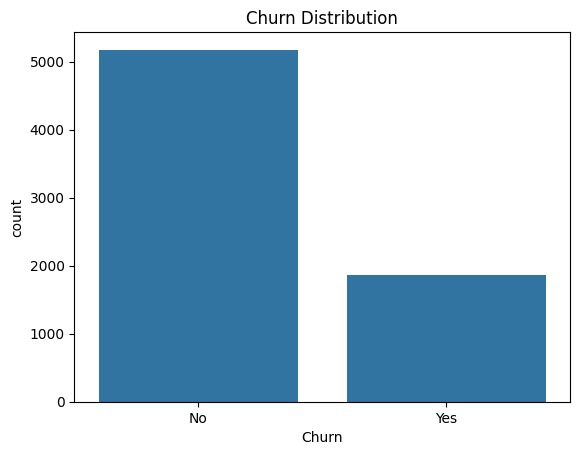

In [4]:
# Churn distribution
# Check class imbalance
print("Churn distribution:\n", y.value_counts(normalize=True))
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [5]:
# Identify feature types
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])


In [6]:
# Define pipelines with class balancing
pipelines = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced'))
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(scale_pos_weight=y.value_counts()[0]/y.value_counts()[1],
                                     use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
}


In [7]:
# Function to evaluate model
def evaluate_model_cv(name, model):
    roc_auc_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f'\n{name} Cross-Validation ROC AUC Scores: {roc_auc_scores}')
    print(f"{name} Mean ROC AUC: {roc_auc_scores.mean():.4f}")
    return {
        'Model': name,
        'Mean ROC AUC': roc_auc_scores.mean()
    }

# Evaluate all models
results = []
for name, pipeline in pipelines.items():
    result = evaluate_model_cv(name, pipeline)
    results.append(result)



Logistic Regression Cross-Validation ROC AUC Scores: [0.85632799 0.85856519 0.83386422 0.83724858 0.83696046]
Logistic Regression Mean ROC AUC: 0.8446

Decision Tree Cross-Validation ROC AUC Scores: [0.72276473 0.7197706  0.68766953 0.67215034 0.7011127 ]
Decision Tree Mean ROC AUC: 0.7007

Random Forest Cross-Validation ROC AUC Scores: [0.84903511 0.84625281 0.81352528 0.81976014 0.82341822]
Random Forest Mean ROC AUC: 0.8304


C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:06:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:06:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:06:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarni


XGBoost Cross-Validation ROC AUC Scores: [0.82956418 0.84496887 0.80952492 0.81371696 0.82285967]
XGBoost Mean ROC AUC: 0.8241



Model Performance Summary (Cross-Validated):
                 Model  Mean ROC AUC
0  Logistic Regression      0.844593
2        Random Forest      0.830398
3              XGBoost      0.824127
1        Decision Tree      0.700694


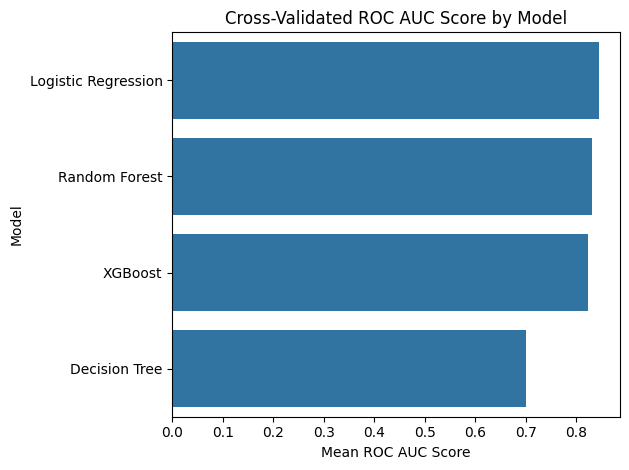

In [12]:
# Performance summary
results_df = pd.DataFrame(results)
print("\nModel Performance Summary (Cross-Validated):")
print(results_df.sort_values(by='Mean ROC AUC', ascending=False))

# Plot comparison
sns.barplot(x='Mean ROC AUC', y='Model', data=results_df.sort_values(by='Mean ROC AUC', ascending=False))
plt.title('Cross-Validated ROC AUC Score by Model')
plt.xlabel('Mean ROC AUC Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

In [14]:
# Save best model
best_model_name = results_df.sort_values(by='Mean ROC AUC', ascending=False).iloc[0]['Model']
best_pipeline = pipelines[best_model_name]
best_pipeline.fit(X, y)
model_filename = f"{best_model_name.lower().replace(' ', '_')}_pipeline.pkl"
joblib.dump(best_pipeline, model_filename)
print(f"\nSaved best model: {best_model_name} to '{model_filename}'")



Saved best model: Logistic Regression to 'logistic_regression_pipeline.pkl'
